In [ ]:
!conda install -c intel scikit-learn

# Training a sentiment analysis classifier based on supervised machine learning algorithms

In [1]:
import string

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
stop_words = set(stopwords.words('spanish'))

In [4]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading labeled tweets

In [5]:
# Dataset loaded from: https://docs.google.com/spreadsheets/d/11_E2ngsEOyTQwbwVVRHY5urzFF95BQCV/edit#gid=1788161364
tweets_df = pd.read_csv('./data/tweets_escenario1.2.csv', sep = ',')

In [6]:
tweets_df.shape

(627, 3)

In [7]:
tweets_df.head()

,full_text,sentiment,emotion
0,"@IvanDuque Sus socios de las AGC tienen este platanal vuelto mierda, pero no haces nada, usted inservible, ha logrado la peor inflación en Colombia y solo pública maricadas sin sentido, se robó las elecciones para entregar el país, valiente idiota tenemos de presidente.",negative,anger
1,@AlvaroUribeVel Ellos también celebran por que Maduro PetroGustavo Ivan Cepeda Timo Teodora Bobolivar entre muchos más sufren de insomnio.\nUribe Velez Alvarito no los deja dormir\nEl enemigo para las elecciones no es Fico.... Sino el Excelentísimo y más Grande Presidente que ha tenido Colombia,negative,anger
2,"@PDleh @cokycafe @PGN_COL En Colombia existen miles de leyes para controlar los funcionarios públicos pero a la hora de aplicarlas ""se les olvida que existen"". ¿Que más pruebas quieren? ¿Porque avalan unas elecciones, las del 13 de marzo, donde pado de todo lo que no debía de pasar? Escuchamos respuestas",negative,anger
3,Petro ahora es el Capitán América o mejor dicho el Capitán Colombia de ganar las elecciones. No soltara el escudo ni para dormir 😂 https://t.co/k56Dv7id1J,negative,joy
4,"#OtraPregunta \n""Petro promete reanudar relaciones diplomáticas con Maduro si gana elecciones en Colombia""...\nEsto no pinta nada bien... y si además gana Lula en Brasil...\n¿Esto como que va para largo? https://t.co/wpQsl5KoRe",negative,fear


In [8]:
tweets_df.sample(n=500, random_state=5)

,full_text,sentiment,emotion
445,#QuienRespondePor\nQueman carro de @UNALOficial Universidad Nacional en Santa Fe de Antioquia. El @COL_EJERCITO y la @PoliciaColombia Se escondieron no Actúan Parece ser el excenario para una Guerra Civil y así evitar Elecciones Presidenciales en Colombia @bbcmundo https://t.co/SWEo3DvigS,negative,joy
230,En Colombia hace falta un presidente como @nayibbukele que no le teme a nada y va de frente contra las fuerzas oscuras aliadas con políticos que lo único que buscas es inestabilidad en el país previo a elecciones.,positive,sadness
289,O sea que el miserable de Macías reconoce que en Colombia es Fácil robar elecciones. Bellaco.,negative,anger
622,"En los consulados de Colombia en el exterior se adelantan las pruebas de funcionalidad para las elecciones de presidente y vicepresidente de la república. En el país, la Registraduría Nacional alista los simulacros para los comicios del 29 de mayo.\n\n#GarantesDeLaDemocracia https://t.co/7NOQaPod0z",neutral,joy
361,"Exigimos garantías para la vida y la democracia. A 24 días de elecciones, #Colombia se encuentra sitiada por las mafias del #ClanDelGolfo sin que el gobierno haga nada! Pedimos a la comunidad internacional pronunciarse inmediatamente.\n\n@WOLA_org #QuienRespondePor #ParoArmado https://t.co/G6qEJKkpcU",negative,anger
...,...,...,...
192,"@PuertaRestrepo4 Pilas amigos colombianos que este tipo @MashiRafael se robó desde la esperanza hasta la banda presidencial de El Ecuador, de billete ni hablar suerte en las elecciones x una colombia sin comunismo",negative,fear
572,"Esto es Colombia hace 50 años, Colombia hace una decada, Colombia todos los días. esto señoras y señores es Colombia a unos cuantos días de elecciones presidenciales en las que "" el candidato de la oposición "" lidera todas las encuestas y los corruptos de siempre no lo soportan. https://t.co/cfHiZMPhbF",negative,anger
54,"fallas que encontró @PGN_COL en elecciones a Congreso https://t.co/6dpBhQIKtW y a pesar de todo los aliados de Petro.. Tibisay Lucena C @CNE_COLOMBIA @Doris_MendezC son tan descarados en afirmar que Las elecciones de congreso fueron transparentes , nos van a robar de nuevo",negative,anger
19,@IvanDuque Quien da vía libre a paramilitares para sitiar a Colombia y y afectar elecciones @ONUHumanRights @MisionONUCol @Declaracion @RIDH_INHR @CorteIDH @OACNUDH https://t.co/fZ2yFvjIwY,negative,fear


In [9]:
df2 = tweets_df.sample(n=500).copy()
len(df2)

500

In [10]:
#df2.to_csv('Dataset.csv')

In [11]:
df2['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.660
neutral     0.274
positive    0.066
Name: sentiment, dtype: float64

In [12]:
df2['emotion'].value_counts(dropna = False, normalize = True)

anger      0.346
fear       0.244
sadness    0.212
joy        0.198
Name: emotion, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [13]:
# Removing  unlabeled tweets
tweets_labeled_df = df2.loc[df2['sentiment'].notnull()]

In [14]:
tweets_labeled_df.shape

(500, 3)

In [15]:
tweets_unlabeled_df = df2.loc[df2['sentiment'].isnull()]

In [16]:
tweets_unlabeled_df.shape

(0, 3)

In [17]:
# Scenario 1: Working with all classes

# Scenario 2: Working only with positive and negative classes
# Removing neutral class
#tweets_labeled_df = tweets_labeled_df.loc[tweets_labeled_df['sentiment'].isin(['positive', 'negative'])]

# Scenario 3: Treating neutral as positive classes
tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral': 'positive'})

### Splitting train and test datasets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.2, stratify = tweets_labeled_df['sentiment'], random_state = 1)


In [19]:
X_train.shape

(400,)

In [20]:
pd.Series(y_train).value_counts(normalize = True)

negative    0.66
positive    0.34
Name: sentiment, dtype: float64

In [21]:
X_test.shape

(100,)

In [22]:
pd.Series(y_test).value_counts(normalize = True)

negative    0.66
positive    0.34
Name: sentiment, dtype: float64

### Vectorizing texts

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="./imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="./imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [23]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [24]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [25]:
X_bow = bow.fit_transform(X_train)

In [26]:
X_tfidf = tfidf.fit_transform(X_train)

### Training and evaluating a model using BOW

In [27]:
model = KNeighborsClassifier(n_neighbors=7)

In [28]:
model.fit(X_bow, y_train)

KNeighborsClassifier(n_neighbors=7)

In [29]:
y_train_bow_predict = model.predict(X_bow)
y_test_bow_predict = model.predict(bow.transform(X_test))

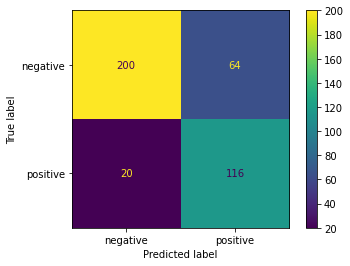

In [30]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

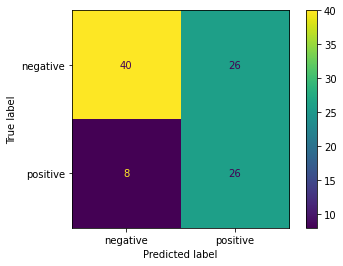

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [32]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 'positive'))

Precision: 0.5
Recall: 0.7647058823529411
F1: 0.6046511627906976


In [33]:
# Metrics calculation for more than two classes
#print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
#print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
#print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

### Training and evaluating a model using TF-IDF

In [34]:
model = KNeighborsClassifier(n_neighbors=7)

In [35]:
model.fit(X_tfidf, y_train)

KNeighborsClassifier(n_neighbors=7)

In [36]:
y_train_tfidf_predict = model.predict(X_tfidf)
y_test_tfidf_predict = model.predict(bow.transform(X_test))

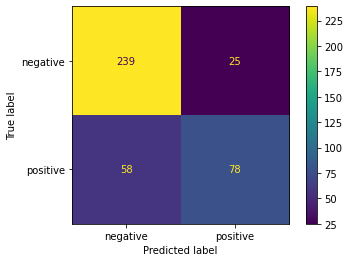

In [37]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

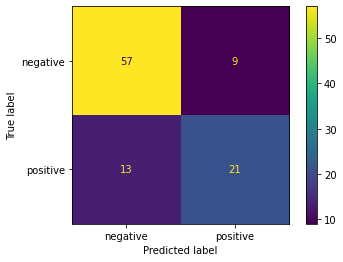

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [39]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))

Precision: 0.7
Recall: 0.6176470588235294
F1: 0.65625


In [40]:
# Metrics calculation for more than two classes
#print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
#print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
#print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

### How interpret the results?

<table>
    <tbody>
        <tr>
            <td>
                <img src="./imgs/confusion-matrix.png" style="height: 400px;">
            </td>
            <td>
                <img src="./imgs/precision-recall.png" style="height: 600px;">
            </td>
        </tr>
    </tbody>
</table>

### Analyzing errors

In [41]:
error_df = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [42]:
error_df.shape

(100, 3)

In [43]:
error_df.loc[error_df['actual'] != error_df['predicted']].head(100)

,full_text,actual,predicted
1,"El izquierdista Gustavo Petro, uno de los favoritos para las elecciones presidenciales de Colombia que se celebrarán a #Petro #reanudará #relacion #Venezuela finales de mes, dijo que de resultar ganador, reanudará las relaciones con Venezuela,\n\nhttps://t.co/mai23eROOt https://t.co/bdtOmt3EfO",positive,negative
5,"¿Enserio?, Es que en Colombia no hay democracia ahora no puede un conservador apoyar a @petrogustavo ¿o que pasa?\nhttps://t.co/ZCVgxM4Kti",negative,positive
8,"Don @fidelcanoco @AlvaroUribeVel logró ganar y en primera vuelta en ambas elecciones, tanto en 2002 con el 53% como lo reseña @elespectador y en 2006 con el 62%. Creo que el reporte quedó ""chueco"". \n https://t.co/qW8sqREwZC",negative,positive
17,"@_RoqueCastro No se procupen. Existe la alternativa que aplicaron el 19 de abril de 1970 cuando le robaron las elecciones a Gustavo Rojas Pinilla y el ""establecimiento"" colombiano crea el M-19, Movimiento 19 de Abril. @ejdecena \nhttps://t.co/fvxvtCKznD",negative,positive
18,Colombia. País de las jugaditas...\n\nCon o sin Ley de garantías el Uribismo siempre ha encontrado y encontrará la manera de amañar elecciones y comprar votos.,negative,positive
19,"@Soylaauraaa @richiparedesh Dios que angustia. Ojalá alguien haga algo. Que impotencia. Si quieren que se queden con las elecciones, pero que dejen a Colombia en paz.",negative,positive
20,Rodolfo Hernández: “Fajardo como que ya pasó a la historia”. \nhttps://t.co/TNKkWRoArj\n\n#Elecciones2022 #ColombiaDecide https://t.co/15lS8za2CK,negative,positive
21,#Elecciones2022\nEn Comité de Seguimiento Electoral de cara a las elecciones del 29 de mayo nuevas conclusiones y peticiones. @MagdalenaGober\n@SantaMartaDTCH\n@Registraduria\n@CNE_COLOMBIA\n👇\n“La Democracia es un compromiso de todos”: @rmontoyai Infante https://t.co/f3XcwEB599,positive,negative
24,"Colombia murió el día q J.M. Santos fué elegido presidente. No fué al azar la denominación ""Día D"" q se le dió al supuesto ""primer día de paz"" luego d la firma d la rendición del estado ante el narcoterrorismo d las farc. No obstante les diremos NO aunque se roben las elecciones. https://t.co/OqmnQdbn8O",negative,positive
32,"@Registraduria @PGN_COL @CGR_Colombia @moecolombia Una pregunta\n\n¿El es quien capacito a los jurados de votación del Pacto Histórico para que pudiera votar 2 veces y así ""democratizar"" con el registrador, Indra y Petro las elecciones al Congreso? \n\n#RegistraduriaCorrupta \n#TibisayVegaRenuncie \n#RegistradorRenuncie",negative,positive
